# Testing of SAMueL-1 synthetic data: Compare differences between synthetic data and real data nearest-neighbours

This notebook shows some examples of synthetic data alongside the nearest-neighbour real data used to create the synthetic data, and show the distribution of distances between real data point nearest neighbours and nearest neighbour distances between synthetic and real data points. Distance between real and synthetic data is measured as Cartesian distance between standardised data for admissions to the same stroke unit.

## Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Turn warnings off to keep notebook clean
import warnings

warnings.filterwarnings("ignore")

## Load data

Load first train/test/synthetic data set

In [2]:
data_loc = './../data/sam_1/kfold_5fold/'

train = pd.read_csv(data_loc + 'train_0.csv')
test = pd.read_csv(data_loc + 'test_0.csv')
synthetic = pd.read_csv(data_loc + 'synthetic_0.csv')

X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
X_synthetic = synthetic.drop('S2Thrombolysis', axis=1)

## Function to standardise data

In [3]:
def standardise_data(X_train, X_test):
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std = sc.transform(X_train)
    test_std = sc.transform(X_test)

    return train_std, test_std

## Function to find nearest neighbour real data point for each synthetic data point.

Uses ScitLearn neighbors.NearestNeighbors algorithm to find nearest neighbour.

In [4]:
def find_distance_to_closest_real_data(X_actual, X_synthetic):
    """
    Find nearest neighbour in the real data set (based on Cartesian distance of
    standardised data).
    """

    # Standardise data (based on real training data)
    X_actual_std, X_synth_std = standardise_data(
        X_actual, X_synthetic)

    # Use ScitLearn neighbors.NearestNeighbors to get nearest neighbour
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_actual_std)
    dists, idxs = nn.kneighbors(X_synth_std)

    # Convert row idxs to index in original index in X_actual
    real_ids = list(X_actual.iloc[idxs.flatten()].index)

    # Store in dictionary
    nearest_neighbours = dict()
    nearest_neighbours['distances'] = list(dists.flatten())
    nearest_neighbours['ids'] = real_ids

    return nearest_neighbours

## Add distance measure and closest neighbour ID to synthetic data

In [5]:
# Loop through stroke teams (calculate distance to patients in same unit)
groups = X_train.groupby('StrokeTeam')

# Set up list for synthetic data for each stroke team
synthetic_dfs = []

# Loop through stroke teams
for index, group_df in groups:
    # Remove StrokeTeam from training data
    actual_train = group_df.drop(['StrokeTeam'], axis=1)

    # Get synthetic data for corresponding stroke team
    mask = X_synthetic['StrokeTeam'] == index
    synthetic_X_unit = X_synthetic[mask].drop(['StrokeTeam'], axis=1)

    # Get nearest neighbour distance and ID
    nearest_neighbours = find_distance_to_closest_real_data(
        actual_train, synthetic_X_unit)

    # Store data for unit in a dataframe
    df = synthetic[mask]
    df['nn_distance'] = nearest_neighbours['distances']
    df['nn_id'] = nearest_neighbours['ids']

    # Append to list of unit dataframes
    synthetic_dfs.append(df)

# Concatenate results and shuffle
synthetic_data_with_distance = pd.concat(synthetic_dfs)
synthetic_data_with_distance = synthetic_data_with_distance.sample(
    frac=1.0, random_state=42)

In [6]:
# Sample 4 synthetic data points
synth_examples = synthetic_data_with_distance.sample(4, random_state=42)
synth_examples.drop(['StrokeTeam', 'S2Thrombolysis'], axis=1, inplace=True)
synth_examples.to_csv('./synth_examples/synth_examples.csv')

# Get IDs for nearest neighboour (in orignal data)
ids = synth_examples['nn_id'].values
real_examples = X_train.iloc[ids]
real_examples.to_csv('./synth_examples/closest_real.csv')

# Standardise
cols = list(X_train.drop('StrokeTeam', axis=1))
X_train_std, real_examples_std = standardise_data(
    X_train[cols], real_examples[cols])
X_train_std, synth_examples_std = standardise_data(
    X_train[cols], synth_examples[cols])

## Plot the four synthetic data points and nearest neighbours

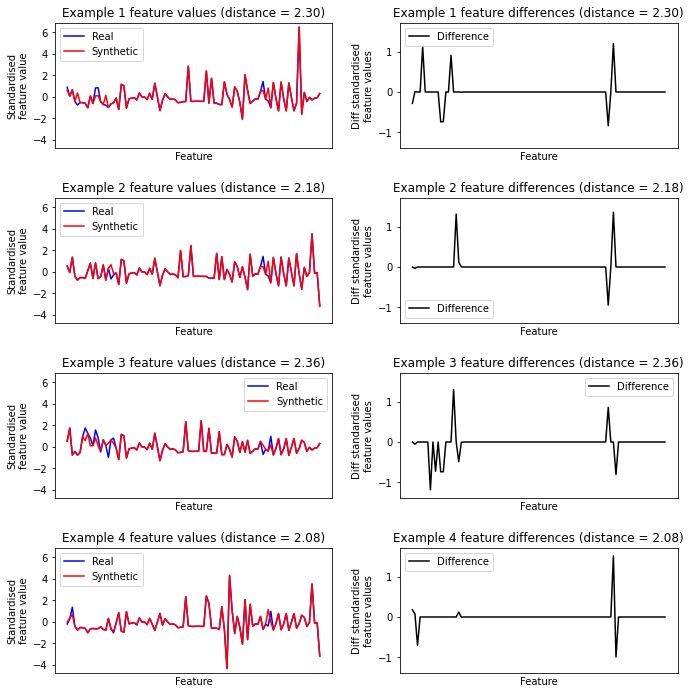

In [7]:
# Get axis limits
value_min = min(np.min(real_examples_std), np.min(synth_examples_std)) - 0.4
value_max = max(np.max(real_examples_std), np.max(synth_examples_std)) + 0.4
diff = synth_examples_std - real_examples_std
diff_min = np.min(diff) - 0.2
diff_max = np.max(diff) + 0.2

fig, ax = plt.subplots(4, 2, figsize=(10, 10))
ax = ax.ravel()
for i in range(4):
    row = i
    y1 = real_examples_std[i]
    y2 = synth_examples_std[i]
    x = range(len(y1))
    ax[row * 2].plot(x, y1, color='b', label='Real')
    ax[row * 2].plot(x, y2, color='r', linestyle='-', label='Synthetic')
    ax[row * 2].get_xaxis().set_ticks([])
    ax[row * 2].set_xlabel('Feature')
    ax[row * 2].set_ylabel('Standardised\nfeature value')
    ax[row * 2].set_ylim(value_min, value_max)
    distance = synth_examples.iloc[i]['nn_distance']
    title = f'Example {i + 1} feature values (distance = {distance:0.2f})'
    ax[row * 2].set_title(title)
    ax[row * 2].legend()

    y = synth_examples_std[i] - real_examples_std[i]
    x = range(len(y1))
    ax[row * 2 + 1].plot(x, y, color='k', label='Difference')
    ax[row * 2 + 1].get_xaxis().set_ticks([])
    ax[row * 2 + 1].set_xlabel('Feature')
    ax[row * 2 + 1].set_ylabel('Diff standardised\nfeature values')
    ax[row * 2 + 1].set_ylim(diff_min, diff_max)
    title = f'Example {i + 1} feature differences (distance = {distance:0.2f})'
    ax[row * 2 + 1].set_title(title)
    ax[row * 2 + 1].legend()

plt.tight_layout(pad=2)
fig.patch.set_facecolor('w')
plt.savefig('./images/nn_examples.png', dpi=300)
plt.show()

## Show four examples of nearest neighbours between real data

Get nearest neighbour distances within the real training set.

For each synthetic data point find the nearest neighbour in real data. Note: When generating synthetic data distances is measured between real and synthetic data for each stroke team separately. Here we look for the nearest real data point in all the real training data.

In [8]:
# Get distance between real data points
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_train_std)
dists, idxs = nn.kneighbors()
dist_real_real = dists.flatten()

Look at four examples of bearesr neighboiur points between real data.

In [9]:
# Sample 4 synthetic data points
np.random.RandomState=42
sample_index = np.random.choice(np.arange(len(X_train)), 4)
real_samples_a = X_train.iloc[sample_index]
closest_neigbour_index = idxs.flatten()[sample_index]
real_samples_b = X_train.iloc[closest_neigbour_index]
real_sample_differences = dists.flatten()[sample_index]

# Save
real_samples_a.to_csv('./synth_examples/real_samples_a.csv')
real_samples_b.to_csv('./synth_examples/real_samples_a_nn.csv')

In [10]:
# Standardise
cols = list(X_train.drop('StrokeTeam', axis=1))
X_train_std, real_samples_a_std = standardise_data(
    X_train[cols], real_samples_a[cols])
X_train_std, real_samples_b_std = standardise_data(
    X_train[cols], real_samples_b[cols])

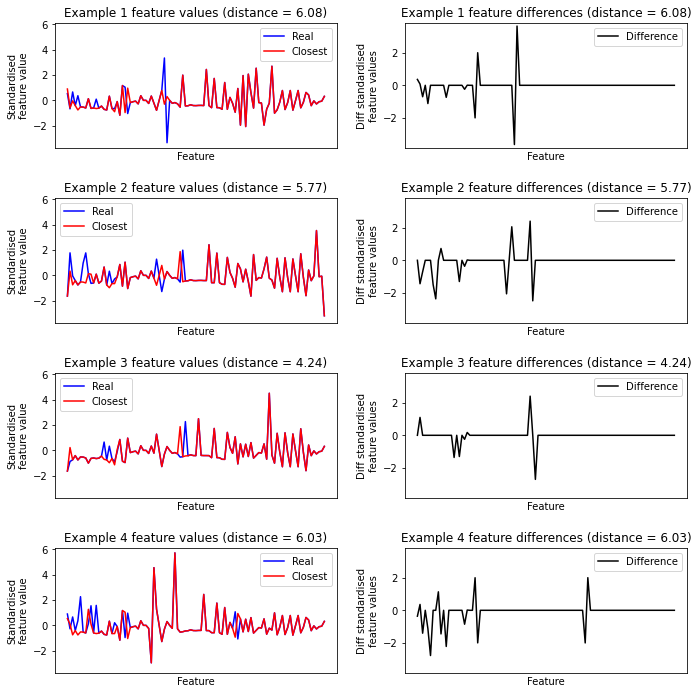

In [11]:
# Get axis limits
value_min = min(np.min(real_samples_a_std), np.min(real_samples_b_std)) - 0.4
value_max = max(np.max(real_samples_a_std), np.max(real_samples_b_std)) + 0.4
diff = real_samples_b_std - real_samples_a_std
diff_min = np.min(diff) - 0.2
diff_max = np.max(diff) + 0.2

fig, ax = plt.subplots(4, 2, figsize=(10, 10))
ax = ax.ravel()
for i in range(4):
    row = i
    y1 = real_samples_a_std[i]
    y2 = real_samples_b_std[i]
    x = range(len(y1))
    ax[row * 2].plot(x, y1, color='b', label='Real')
    ax[row * 2].plot(x, y2, color='r', linestyle='-', label='Closest')
    ax[row * 2].get_xaxis().set_ticks([])
    ax[row * 2].set_xlabel('Feature')
    ax[row * 2].set_ylabel('Standardised\nfeature value')
    ax[row * 2].set_ylim(value_min, value_max)
    distance = real_sample_differences[i]
    title = f'Example {i + 1} feature values (distance = {distance:0.2f})'
    ax[row * 2].set_title(title)
    ax[row * 2].legend()

    y = y = real_samples_b_std[i] - real_samples_a_std[i]
    x = range(len(y1))
    ax[row * 2 + 1].plot(x, y, color='k', label='Difference')
    ax[row * 2 + 1].get_xaxis().set_ticks([])
    ax[row * 2 + 1].set_xlabel('Feature')
    ax[row * 2 + 1].set_ylabel('Diff standardised\nfeature values')
    ax[row * 2 + 1].set_ylim(diff_min, diff_max)
    title = f'Example {i + 1} feature differences (distance = {distance:0.2f})'
    ax[row * 2 + 1].set_title(title)
    ax[row * 2 + 1].legend()

plt.tight_layout(pad=2)
fig.patch.set_facecolor('w')
plt.savefig('./images/nn_examples_real_to_real.png', dpi=300)
plt.show()

## Comparing distances between real data and between synthetic/real data

In [12]:
# Get distance between synthetic and real data points across all units
X_actual_std, X_synthetic_std = standardise_data(
    X_train.drop('StrokeTeam', axis=1),
    X_synthetic.drop('StrokeTeam', axis=1))

dists, idxs = nn.kneighbors(X_synthetic_std)
dist_synthetic_real = dists.flatten()

Get nearest neighbour distances within the synthetic data set.

In [13]:
# Get nerest neighbour distances within synthetic data
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_synthetic_std)
dists, idxs = nn.kneighbors()
dist_synthetic_synthetic = dists.flatten()

Plot histogram.

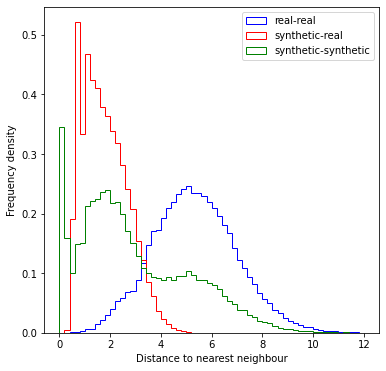

In [14]:
bins = np.arange(0, 12.1, 0.2)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist(dist_real_real, bins=bins, histtype='step', color='b', density=True, label='real-real')
ax.hist(dist_synthetic_real, bins=bins, histtype='step', color='r', density=True, label='synthetic-real')
ax.hist(dist_synthetic_synthetic, bins=bins, histtype='step', color='g', density=True, label='synthetic-synthetic')

ax.set_xlabel('Distance to nearest neighbour')
ax.set_ylabel('Frequency density')
ax.legend()
plt.savefig('./images/nn_hist.png', dpi=300)
plt.show()

Show summary statistics

In [15]:
summary = pd.DataFrame(columns=[
    'Real-Real', 'Synthetic-Real', 'Synthetic-Synthetic'], index=['mean', 'stdev'])
summary['Real-Real']['mean'] = dist_real_real.mean().round(2)
summary['Real-Real']['stdev'] = dist_real_real.std().round(2)
summary['Synthetic-Real']['mean'] = dist_synthetic_real.mean().round(2)
summary['Synthetic-Real']['stdev'] = dist_synthetic_real.std().round(2)
summary['Synthetic-Synthetic']['mean'] = dist_synthetic_synthetic.mean().round(2)
summary['Synthetic-Synthetic']['stdev'] = dist_synthetic_synthetic.std().round(2)
summary.T

,mean,stdev
Real-Real,5.34,1.68
Synthetic-Real,1.8,0.88
Synthetic-Synthetic,2.96,2.16


Proportion of points with effectively zero distance (identical points).

In [16]:
identical = np.mean(dist_real_real < 0.001).round(3)
print('Proportion identical points within real data: ', identical)
identical = np.mean(dist_synthetic_real < 0.001).round(3)
print('Proportion identical between real and synthetic data: ', identical)
identical = np.mean(dist_synthetic_synthetic < 0.001).round(3)
print('Proportion identical within synthetic data: ', identical)

Proportion identical points within real data:  0.0
Proportion identical between real and synthetic data:  0.0
Proportion identical within synthetic data:  0.002


## Observations

* The nearest neighbour distance between synthetic and real data points is generally smaller than the nearest neighbour distance between real data points.

* There are no identical points in the real data or between real and synthetic data. The synthetic data has a small proportion of identical points.